# Importation des bibliothèques

In [48]:
import re
import os
import time
import kagglehub
import keras
import matplotlib.pyplot as plt
import numpy as np
import keras_hub
import keras_tuner
import pandas as pd
import pkuseg
import tensorflow as tf
from datasets import Dataset
from pypinyin import lazy_pinyin
from keras.layers import (
    LSTM,
    GRU,
    Dense,
    Embedding,
    Input,
    Dropout,
    Concatenate,
    Attention,
    MultiHeadAttention,
    LayerNormalization,
    StringLookup,
    TextVectorization,
)
from keras.models import Model
import pickle as pk

# Vérifier GPU
print(tf.config.list_physical_devices('GPU'))
# tf.debugging.set_log_device_placement(True)

seg = pkuseg.pkuseg()
path = kagglehub.dataset_download("noxmoon/chinese-official-daily-news-since-2016")

print("\nPath to dataset files:", path)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Path to dataset files: /Users/perrineqhn/.cache/kagglehub/datasets/noxmoon/chinese-official-daily-news-since-2016/versions/1


# Création du corpus

In [49]:
dataset = pd.read_csv(path+"/chinese_news.csv")
# Print dataset information
print("Dataset information:")
print(dataset.info())
# Print dataset head
print("Dataset head:")
print(dataset.head())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20738 entries, 0 to 20737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      20738 non-null  object
 1   tag       20738 non-null  object
 2   headline  20738 non-null  object
 3   content   20631 non-null  object
dtypes: object(4)
memory usage: 648.2+ KB
None
Dataset head:
         date   tag                                           headline  \
0  2016-01-01  详细全文  陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...   
1  2016-01-01  详细全文                             中央军委印发《关于深化国防和军队改革的意见》   
2  2016-01-01  详细全文                           《习近平关于严明党的纪律和规矩论述摘编》出版发行   
3  2016-01-01  详细全文                                 以实际行动向党中央看齐 向高标准努力   
4  2016-01-01  详细全文                                 【年终特稿】关键之年 改革挺进深水区   

                                             content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...  
1  经中央军委主席习近平批准，中央军委近日印发了《关

In [50]:
# Prétraitement de content (suppression des caractères non chinois, normalisation des espaces)
def clean_content(text):
    if not isinstance(text, str):
        return ""
    
    # Garder les caractères chinois et ponctuation chinoise
    text = re.sub(r"[^\u4e00-\u9fff\u3000-\u303F\uff00-\uffef]", "", text)
    
    # Normaliser les espaces (rare, mais au cas où)
    text = text.replace(" ", "").strip()

    return text

# Remplacer les valeurs manquantes par une chaîne vide
dataset["content"] = dataset["content"].fillna("")

# Appliquer le prétraitement à la colonne 'content'
dataset['cleaned_content'] = dataset['content'].apply(clean_content)

# Filtrer les lignes où 'cleaned_content' est vide
dataset = dataset[dataset["cleaned_content"].str.strip() != ""].reset_index(drop=True)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after preprocessing:")
print(dataset[['content', 'cleaned_content']].head())


dataset["tokens"] = dataset["cleaned_content"].apply(lambda x: seg.cut(x))

# Aperçu
print(dataset["tokens"].head())

Dataset after preprocessing:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                                     cleaned_content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会年月日在...  
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。《意见》强调，...  
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...  
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...  
4  刚刚过去的年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，集中发力...  
0    [中国, 人民, 解放军, 陆军, 领导, 机构, 、, 中国, 人民, 解放军, 火箭军,...
1    [经, 中央军委, 主席, 习近平, 批准, ，, 中央军委, 近日, 印发, 了, 《, ...
2    [由, 中共中央, 纪律, 检查, 委员会, 、, 中共中央, 文献, 研究室, 编辑, 的...
3    [广大, 党员, 干部, 正在, 积极, 学习, 习近平, 总书记, 在, 中央, 政治局,...
4    [刚刚, 过去, 的, 年, ，, 是, 全面, 深化, 改革, 的, 关键, 之, 年, ...
Name: tokens, dtype: object


Cette cellule convertit le texte segmenté en séquences combinant chaque caractère chinois, son pinyin (romanisation), et son code T9 correspondant (basé sur un mappage prédéfini). Une fonction `pinyin_to_t9` traduit le pinyin en codes T9, et `generer_sequence_contextuell` crée des triplets (caractère|pinyin|T9) pour chaque mot. Les séquences sont stockées dans une nouvelle colonne et sauvegardées dans un fichier CSV

In [51]:
# convert the content column to pinyin
t9_map = {
    "@": "1", ".": "1", ":": "1",
    "a": "2", "b": "2", "c": "2",
    "d": "3", "e": "3", "f": "3",
    "g": "4", "h": "4", "i": "4",
    "j": "5", "k": "5", "l": "5",
    "m": "6", "n": "6", "o": "6",
    "p": "7", "q": "7", "r": "7", "s": "7",
    "t": "8", "u": "8", "v": "8",
    "w": "9", "x": "9", "y": "9", "z": "9",
    "1": "1", "2": "2", "3": "3", "4": "4",
    "5": "5", "6": "6", "7": "7", "8": "8",
    "9": "9", "0": "0", " ": "0",
    "。":"。", "，":"，", "？":"？", "！":"！",
}

# Fonction pour convertir une chaîne de caractères en code T9
def pinyin_to_t9(text):
    t9_code = ""
    if pd.isna(text):
        return ""
    for char in text.lower():
        t9_code += t9_map.get(char, char)  # Conserver les caractères non mappés
    return t9_code

def validate_t9(t9_code):
    # Vérifie que le code T9 est numérique (ou vide pour ponctuation)
    return bool(re.match(r'^[0-9]+$', t9_code)) or t9_code in {"。", "，", "？", "！"}

def generer_sequence_contextuelle(row):
    tokens = row["tokens"]
    sequence = []
    for token in tokens:
        if not isinstance(token, str) or not re.search(r'[\u4e00-\u9fff]', token):
            continue
        for char, py in zip(token, lazy_pinyin(token)):
            t9 = pinyin_to_t9(py)
            if validate_t9(t9):  # Vérifier que le T9 est valide
                sequence.append(f"{char}|{py}|{t9}")
    return ' '.join(sequence)

dataset["char_pinyin_t9_sequence"] = dataset.apply(generer_sequence_contextuelle, axis=1)

# Filtrer les lignes où 'char_pinyin_t9_sequence' est vide
dataset = dataset[dataset["char_pinyin_t9_sequence"].str.strip() != ""].reset_index(drop=True)

# Sauvegarder le fichier
if not os.path.exists("dataset"):
    os.makedirs("dataset")
dataset[["char_pinyin_t9_sequence"]].to_csv("dataset/sequences_char_pinyin_t9.csv", index=False)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after generating sequences:")
print(dataset[['content', 'char_pinyin_t9_sequence']].head())

Dataset after generating sequences:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                             char_pinyin_t9_sequence  
0  中|zhong|94664 国|guo|486 人|ren|736 民|min|646 解|...  
1  经|jing|5464 中|zhong|94664 央|yang|9264 军|jun|58...  
2  由|you|968 中|zhong|94664 共|gong|4664 中|zhong|94...  
3  广|guang|48264 大|da|32 党|dang|3264 员|yuan|9826 ...  
4  刚|gang|4264 刚|gang|4264 过|guo|486 去|qu|78 的|de...  


# Création du dataset pour le modèle

Cette section prépare les données pour l'entraînement du modèle en définissant des séquences de contexte, d'entrée T9 et de cibles (caractères chinois à prédire). Les données sont structurées dans un format adapté à TensorFlow.

In [67]:
# Initialisation des constantes
MAX_SEQ_LEN = 100

## Génération des séquences contextuelles
Ici, les séquences sont générées à partir des triplets caractère|pinyin|T9. 
Pour chaque position dans une séquence, elle extrait :

- Contexte : les caractères précédents,
- Entrée T9 : les codes T9 suivants,
- Cible : les caractères à prédire.

Les résultats sont organisés dans un DataFrame pour une manipulation facile.

In [68]:
dataset = dataset[["char_pinyin_t9_sequence"]]

# Modifier la génération des séquences pour inclure le contexte
input_t9_sequences = []
context_char_sequences = []
target_char_sequences = []

for seq in dataset["char_pinyin_t9_sequence"]:
    triplets = seq.strip().split(" ")
    t9_seq = []
    char_seq = []
    
    for triplet in triplets:
        parts = triplet.split("|")
        if len(parts) == 3:
            char, _, t9 = parts
            if validate_t9(t9):
                char_seq.append(char)
                t9_seq.append(t9)
    
    # Créer des paires contexte-T9-cible
    for i in range(1, len(t9_seq)):
        # Contexte : caractères avant la position i
        context = char_seq[:i][-MAX_SEQ_LEN:]
        # Entrée T9 : codes T9 à partir de i
        t9_input = t9_seq[i:i+MAX_SEQ_LEN]
        # Cible : caractères à partir de i
        target = char_seq[i:i+MAX_SEQ_LEN]
        
        if context and t9_input and target:
            context_char_sequences.append("".join(context))
            input_t9_sequences.append(" ".join(t9_input))
            target_char_sequences.append("".join(target))

# Créer un DataFrame
df_sequences = pd.DataFrame({
    "context_char_sequence": context_char_sequences,
    "input_t9_sequence": input_t9_sequences,
    "target_char_sequence": target_char_sequences
})

# Filtrer les séquences vides
df_sequences = df_sequences[
    (df_sequences["context_char_sequence"].str.strip() != "") &
    (df_sequences["input_t9_sequence"].str.strip() != "") &
    (df_sequences["target_char_sequence"].str.strip() != "")
]

In [69]:
print("DataFrame sequences:")
print(df_sequences.head())

# Sauvegarder le DataFrame dans un fichier pickle
df_sequences.to_pickle("dataset/sequences_char_pinyin_t9.pkl")

DataFrame sequences:
  context_char_sequence                                  input_t9_sequence  \
0                     中  486 736 646 543 3264 586 58 586 5464 326 54 46...   
1                    中国  736 646 543 3264 586 58 586 5464 326 54 468 94...   
2                   中国人  646 543 3264 586 58 586 5464 326 54 468 94664 ...   
3                  中国人民  543 3264 586 58 586 5464 326 54 468 94664 486 ...   
4                 中国人民解  3264 586 58 586 5464 326 54 468 94664 486 736 ...   

                                target_char_sequence  
0  国人民解放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大...  
1  人民解放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大楼...  
2  民解放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大楼隆...  
3  解放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大楼隆重...  
4  放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大楼隆重举...  


## Encoder les données pour Keras

Cette sous-section prépare les données pour l'entraînement avec Keras en les chargeant depuis le fichier pickle et en les convertissant en un dataset TensorFlow optimisé.

In [70]:
# Charger le fichier pickle
df_sequences = pd.read_pickle("dataset/sequences_char_pinyin_t9.pkl")

# Afficher les 5 premières lignes du DataFrame
print("DataFrame sequences:")
print(df_sequences.head())

DataFrame sequences:
  context_char_sequence                                  input_t9_sequence  \
0                     中  486 736 646 543 3264 586 58 586 5464 326 54 46...   
1                    中国  736 646 543 3264 586 58 586 5464 326 54 468 94...   
2                   中国人  646 543 3264 586 58 586 5464 326 54 468 94664 ...   
3                  中国人民  543 3264 586 58 586 5464 326 54 468 94664 486 ...   
4                 中国人民解  3264 586 58 586 5464 326 54 468 94664 486 736 ...   

                                target_char_sequence  
0  国人民解放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大...  
1  人民解放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大楼...  
2  民解放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大楼隆...  
3  解放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大楼隆重...  
4  放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一大楼隆重举...  


Cette cellule convertit les séquences en un dataset TensorFlow, les regroupe par lots de 256, et optimise les performances avec prefetch. Le dataset est ensuite sauvegardé pour une utilisation future.

In [ ]:
tf_dataset = tf.data.Dataset.from_tensor_slices((
    df_sequences["context_char_sequence"].values,
    df_sequences["input_t9_sequence"].values,
    df_sequences["target_char_sequence"].values
)).batch(256).prefetch(tf.data.AUTOTUNE)

tf_dataset.take(1).get_single_element()

# Sauvegarder le tensorflow dataset
tf.data.Dataset.save(tf_dataset, "dataset/tf_dataset")

In [87]:
# Charger le tensorflow dataset
tf_dataset = tf.data.Dataset.load("dataset/tf_dataset")

# Afficher les 5 premières lignes du DataFrame
for context, input_t9, target in tf_dataset.take(1):
    print("Context:", context.numpy())
    print("Input T9:", input_t9.numpy())
    print("Target:", target.numpy())

Context: [b'\xe4\xb8\xad' b'\xe4\xb8\xad\xe5\x9b\xbd'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b\xe9\xa2\x86'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b\xe9\xa2\x86\xe5\xaf\xbc'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b\xe9\xa2\x86\xe5\xaf\xbc\xe6\x9c\x

Cette cellule configure trois couches TextVectorization pour transformer les séquences textuelles en vecteurs numériques, nécessaires pour l’entraînement d’un modèle Keras.

- `context_tv` vectorise le contexte (caractères chinois) en découpant par caractère (`split='character'`).
- `input_t9_tv` vectorise les séquences T9 (codes numériques) en découpant par espaces (`split='whitespace'`).
- `target_tv` vectorise la cible (caractères chinois) en découpant par caractère.
    Chaque couche produit des entiers (`output_mode='int'`) et conserve les longueurs variables des séquences (`ragged=True`). Ensuite, trois datasets intermédiaires (`context_ds`, `t9_ds`, `target_ds`) sont créés à partir de `tf_dataset` en extrayant respectivement le contexte, l’entrée T9 et la cible, avec une optimisation parallèle via `num_parallel_calls=tf.data.AUTOTUNE`.

In [ ]:
# TextVectorization pour le contexte, T9 et cible
context_tv = keras.layers.TextVectorization(
    output_mode='int',
    split='character',
    standardize=None,
    ragged=True
)

input_t9_tv = keras.layers.TextVectorization(
    output_mode='int',
    split='whitespace',
    standardize=None,
    ragged=True
)

target_tv = keras.layers.TextVectorization(
    output_mode='int',
    split='character',
    standardize=None,
    ragged=True
)


# Adapter les vectoriseurs
context_ds = tf_dataset.map(
    lambda context, t9, target: context,
    num_parallel_calls=20
)
t9_ds = tf_dataset.map(
    lambda context, t9, target: t9,
    num_parallel_calls=20
)
target_ds = tf_dataset.map(
    lambda context, t9, target: target,
    num_parallel_calls=20
)

Cette cellule adapte les couches de vectorisation aux données correspondantes pour qu’elles apprennent leur vocabulaire respectif. Le temps d’adaptation est mesuré pour chaque couche :

- `context_tv` est adapté au contexte (`context_ds`),
- `input_t9_tv` à l’entrée T9 (`t9_ds`),
- `target_tv` à la cible (`target_ds`).
    Pour la cible, les tokens spéciaux `<START>` et `<END>` sont ajoutés manuellement au vocabulaire s’ils n’y sont pas déjà, pour marquer le début et la fin des séquences lors de l’entraînement. La taille du vocabulaire cible et les indices de ces tokens sont affichés pour vérification. Enfin, les formes (`shape`) des données brutes d’un échantillon sont imprimées pour confirmer leur structure avant vectorisation.

In [89]:
# Adapter les TextVectorization layers
start = time.time()
context_tv.adapt(context_ds)
print(f"Adapt context_tv: {time.time() - start:.2f} seconds")

start = time.time()
input_t9_tv.adapt(t9_ds)
print(f"Adapt input_t9_tv: {time.time() - start:.2f} seconds")

start = time.time()
target_tv.adapt(target_ds)
# Ajouter <START> et <END> au vocabulaire cible
target_vocab = target_tv.get_vocabulary()
if "<START>" not in target_vocab or "<END>" not in target_vocab:
    updated_vocab = ["<START>", "<END>"] + [tok for tok in target_vocab if tok not in ["", "[UNK]"]]
    target_tv.set_vocabulary(updated_vocab)
print(f"Adapt target_tv: {time.time() - start:.2f} seconds")
print(f"Target vocab size: {target_tv.vocabulary_size()}")

Adapt context_tv: 194.41 seconds
Adapt input_t9_tv: 259.83 seconds
Adapt target_tv: 206.89 seconds
Target vocab size: 4598


In [90]:
# Vérification
input_vocab = input_t9_tv.get_vocabulary()
print(input_vocab[:20])

target_vocab = target_tv.get_vocabulary()
print(f"\n<START> index: {target_vocab.index('<START>')}")
print(f"<END> index: {target_vocab.index('<END>')}")
print(target_vocab[:20]) 


# Shape des données
for context, input_t9, target in tf_dataset.take(1):
    print("\nContext shape:", context.shape)
    print("Input T9 shape:", input_t9.shape)
    print("Target shape:", target.shape)

['', '[UNK]', np.str_('94'), np.str_('54'), np.str_('744'), np.str_('33'), np.str_('43'), np.str_('98'), np.str_('486'), np.str_('32'), np.str_('9426'), np.str_('94664'), np.str_('5426'), np.str_('944'), np.str_('926'), np.str_('74'), np.str_('3264'), np.str_('546'), np.str_('934'), np.str_('4664')]

<START> index: 2
<END> index: 3
['', '[UNK]', np.str_('<START>'), np.str_('<END>'), np.str_('的'), np.str_('国'), np.str_('中'), np.str_('一'), np.str_('和'), np.str_('在'), np.str_('人'), np.str_('大'), np.str_('发'), np.str_('作'), np.str_('会'), np.str_('了'), np.str_('全'), np.str_('要'), np.str_('年'), np.str_('展')]

Context shape: (100,)
Input T9 shape: (100,)
Target shape: (100,)


In [75]:
if not os.path.exists("vectorizers"):
    os.makedirs("vectorizers")

# Sauvegarder les vectorizers
with open("vectorizers/context_tv.pkl", "wb") as f:
    pk.dump(context_tv, f)

with open("vectorizers/input_t9_tv.pkl", "wb") as f:
    pk.dump(input_t9_tv, f)

with open("vectorizers/target_tv.pkl", "wb") as f:
    pk.dump(target_tv, f)

Cette cellule définit une fonction `transform_ds` qui vectorise les séquences et prépare les données pour un modèle de type encodeur-décodeur. Elle :

- Vectorise le contexte, l’entrée T9 et la cible avec les couches adaptées, en convertissant les séquences en tenseurs avec padding (`to_tensor(default_value=0)`).
- Crée une entrée pour le décodeur (`decoder_in`) en ajoutant le token `<START>` au début de la séquence cible décalée (excluant le dernier élément).
  La fonction est appliquée au dataset avec `map(transform_ds)`, produisant un nouveau dataset transformé (`transformed_tf_dataset`). Un échantillon est affiché avec ses formes pour vérifier que la transformation est correcte.

In [91]:
start_token_idx = target_tv.get_vocabulary().index("<START>")

# Transformer le dataset
def transform_ds(context, t9, target):
    """ 
    Transforme le dataset pour le modèle en ajoutant le contexte, le T9 et la cible.
    Le contexte est vectorisé et le T9 est vectorisé.
    """
    # Vectoriser le contexte, T9 et cible (to_tensor afin de les transformer en tenseurs au lieu de listes)
    vectorized_context = context_tv(context).to_tensor(default_value=0) # default_value=0 => padding
    vectorized_t9 = input_t9_tv(t9).to_tensor(default_value=0)
    vectorized_target = target_tv(target).to_tensor(default_value=0)
    return (vectorized_context, vectorized_t9), vectorized_target

transformed_tf_dataset = tf_dataset.map(transform_ds, num_parallel_calls=20)

transformed_tf_dataset.padded_batch(256).prefetch(tf.data.AUTOTUNE).take(1).get_single_element()

((<tf.Tensor: shape=(256, 100, 100), dtype=int64, numpy=
  array([[[   4,    0,    0, ...,    0,    0,    0],
          [   4,    3,    0, ...,    0,    0,    0],
          [   4,    3,    9, ...,    0,    0,    0],
          ...,
          [   4,    3,    9, ...,    7,    0,    0],
          [   4,    3,    9, ...,    7,    4,    0],
          [   4,    3,    9, ...,    7,    4,   78]],
  
         [[   3,    9,   21, ...,    4,   78,  103],
          [   9,   21,  249, ...,   78,  103,   74],
          [  21,  249,  247, ...,  103,   74,  150],
          ...,
          [   4,   78,  103, ...,  309, 1291,  392],
          [  78,  103,   74, ..., 1291,  392,  406],
          [ 103,   74,  150, ...,  392,  406,   19]],
  
         [[  74,  150,   36, ...,  406,   19,   34],
          [ 150,   36,  347, ...,   19,   34,   86],
          [  36,  347,  127, ...,   34,   86,    4],
          ...,
          [ 406,   19,   34, ...,  778,   40,  244],
          [  19,   34,   86, ...,   40,  2

## Split train-valid-test

Cette cellule divise le dataset transformé en trois ensembles : entraînement (80 %), validation (10 %) et test (10 %). Le nombre total d’échantillons (c) est calculé avec `reduce`, puis le dataset est mélangé aléatoirement avec `shuffle` (seed fixé à 42 pour reproductibilité). Les tailles des ensembles sont déterminées par des proportions, et les sous-ensembles sont créés avec `take` et `skip`. Chaque ensemble est optimisé avec `prefetch` pour améliorer les performances. Les tailles finales sont affichées pour vérification.

In [62]:
c = transformed_tf_dataset.reduce(0, lambda x, _: x + 1).numpy()
shuffled_ds = transformed_tf_dataset.shuffle(buffer_size=c+100, seed=42)

train_size = c * 80 // 100
test_size = c * 10 // 100
val_size = c - train_size - test_size

ds_train = shuffled_ds.take(train_size).prefetch(tf.data.AUTOTUNE)
ds_val = shuffled_ds.skip(train_size).take(val_size).prefetch(tf.data.AUTOTUNE)
ds_test = shuffled_ds.skip(train_size+val_size).take(test_size).prefetch(tf.data.AUTOTUNE)

print("Taille du train :", ds_train.cardinality().numpy())
print("Taille du validation :", ds_val.cardinality().numpy())
print("Taille du test :", ds_test.cardinality().numpy())

Taille du train : 18807
Taille du validation : 2352
Taille du test : 2350


In [63]:
# Visualisation des données
print("Exemple de données :")
for (context, t9, dec_in), target in ds_train.take(1):
    print(f"Context: {context[0]}")
    print(f"T9: {t9[0]}")
    print(f"Decoder input: {dec_in[0]}")
    print(f"Target: {target[0]}")

    # Afficher les shapes
    print(f"\nContext shape: {context.shape}")
    print(f"T9 shape: {t9.shape}")
    print(f"Decoder input shape: {dec_in.shape}")
    print(f"Target shape: {target.shape}")

Exemple de données :
Context: [699  40 133  21 368 212   0   0   0   0]
T9: [75 11  7 41 13  2 74 33 57 74]
Decoder input: [  2  42   6   5 533 627 423 147 293 890]
Target: [ 42   6   5 533 627 423 147 293 890 147]

Context shape: (256, 10)
T9 shape: (256, 10)
Decoder input shape: (256, 10)
Target shape: (256, 10)


2025-04-15 16:29:11.416329: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
# Sauvegarder les datasets d'entraînement
ds_train.save("train_dataset")
ds_val.save("val_dataset")
ds_test.save("test_dataset")

# Modèle

Sogou T9 est une méthode d’entrée intelligente qui :

- Prend des séquences numériques (ex. : "94664 486" pour "zhong guo").
- Génère des séquences de caractères chinois (ex. : "中国").
- Utilise le contexte (mots précédents) pour désambiguïser les prédictions.
- Est optimisé pour la vitesse et la précision, souvent avec des modèles entraînés sur de vastes corpus.

Pour reproduire cela, il faut utiliser un modèle seq2seq avec un encodeur-décodeur (2 entrées) :

- Encodeur : Lit la séquence T9 et la compresse en une représentation contextuelle.
- Décodeur : Génère la séquence de caractères chinois à partir de cette représentation.

[Functional API](https://keras.io/guides/functional_api/)

Schéma conceptuel :

[Contexte sinogrammes] -> [LSTM Encodeur Contexte] -> [Représentation contexte] </br>
[T9 entrée]           -> [LSTM Encodeur T9]       -> [Représentation T9] </br>
[Représentations contexte + T9] -> [Attention] -> [LSTM Décodeur] -> [Sortie caractères]

In [2]:
# Charger les datasets d'entraînement
ds_train = tf.data.Dataset.load("train_dataset")
ds_val = tf.data.Dataset.load("val_dataset")
ds_test = tf.data.Dataset.load("test_dataset")

# Vérifier les datasets
for (context, t9, dec_in), target in ds_train.take(1):
    print(f"Context: {context[0]}")
    print(f"T9: {t9[0]}")
    print(f"Decoder input: {dec_in[0]}")
    print(f"Target: {target[0]}")

Context: [ 295   66  122 1126  235   66   77  980  267 1439]
T9: [ 8 31  6 95 14  3  6 40  2 23]
Decoder input: [   2  112  750 1208 1641  165  154    9  265   71]
Target: [ 112  750 1208 1641  165  154    9  265   71   76]


2025-04-15 14:31:05.529808: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-15 14:31:05.529832: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-15 14:31:05.529837: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1744720265.529848 24577881 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744720265.529864 24577881 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-04-15 14:31:05.568719: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Charger les vectorizers
with open("vectorizers/context_tv.pkl", "rb") as f:
    context_tv = pk.load(f)

with open("vectorizers/input_t9_tv.pkl", "rb") as f:
    input_t9_tv = pk.load(f)

with open("vectorizers/target_tv.pkl", "rb") as f:
    target_tv = pk.load(f)

# Vérifier les vectorizers
print(f"Context vocab size: {context_tv.vocabulary_size()}")
print(f"Input T9 vocab size: {input_t9_tv.vocabulary_size()}")
print(f"Target vocab size: {target_tv.vocabulary_size()}")

Context vocab size: 4593
Input T9 vocab size: 217
Target vocab size: 4598


In [42]:
# plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
def build_simple_model(rnn_units=64, output_dim=32, dropout_rate=0.2):
    # -- Encoder Context --
    context_input = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="context_input")
    context_embedding = Embedding(input_dim=context_tv.vocabulary_size(), output_dim=output_dim)(context_input)
    context_embedding = keras.layers.LayerNormalization()(context_embedding)
    context_embedding = Dropout(dropout_rate)(context_embedding)
    context_conv = keras.layers.Conv1D(output_dim, kernel_size=3, padding='same', use_bias=False, name="conv")(context_embedding)
    context_conv = context_conv + context_embedding
    context_lstm = LSTM(rnn_units, return_sequences=True, return_state=True)
    context_lstm_out, context_state_h, context_state_c = context_lstm(context_conv)
    context_lstm_out = Dropout(dropout_rate)(context_lstm_out)
    
    # -- Encoder T9 --
    t9_input = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="t9_input")
    t9_embedding = Embedding(input_dim=input_t9_tv.vocabulary_size(), output_dim=output_dim, mask_zero=True)(t9_input)
    t9_embedding = keras.layers.LayerNormalization()(t9_embedding)
    t9_embedding = Dropout(dropout_rate)(t9_embedding)
    t9_conv = keras.layers.Conv1D(output_dim, kernel_size=3, padding='same', use_bias=False, name="conv_t9")(t9_embedding)
    t9_conv = t9_conv + t9_embedding
    t9_lstm = LSTM(rnn_units, return_sequences=True, return_state=True)
    t9_lstm_out, t9_state_h, t9_state_c = t9_lstm(t9_conv)
    t9_lstm_out = Dropout(dropout_rate)(t9_lstm_out)
    
    # -- Combinaison des états --
    combined_state_h = Dense(rnn_units, activation='tanh')(Concatenate(axis=-1, name="concatenated_state_h")([context_state_h, t9_state_h]))
    combined_state_c = Dense(rnn_units, activation='tanh')(Concatenate(axis=-1, name="concatenated_state_c")([context_state_c, t9_state_c]))

    # -- Decoder --
    decoder_input = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="decoder_input")
    decoder_embedding = Embedding(input_dim=target_tv.vocabulary_size(), output_dim=output_dim, mask_zero=True)(decoder_input)
    decoder_embedding = keras.layers.LayerNormalization()(decoder_embedding)
    decoder_embedding = Dropout(dropout_rate)(decoder_embedding)
    decoder_conv = keras.layers.Conv1D(output_dim, kernel_size=3, padding='same', use_bias=False, name="conv_decoder")(decoder_embedding)
    decoder_embedding = decoder_embedding + decoder_conv
    decoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True)
    decoder_lstm_out, _, _ = decoder_lstm(decoder_embedding, initial_state=[combined_state_h, combined_state_c])
    decoder_lstm_out = Dropout(dropout_rate)(decoder_lstm_out)
    
    output = Dense(target_tv.vocabulary_size(), activation='softmax')(decoder_lstm_out)
    
    model = Model(inputs=[context_input, t9_input, decoder_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_simple = build_simple_model()
keras.utils.plot_model(model_simple, show_shapes=True, show_layer_names=True, to_file='model_simple.png')

Epoch 1/10


/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv_decoder' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


   48/18807 ━━━━━━━━━━━━━━━━━━━━ 13:40 44ms/step - accuracy: 0.0131 - loss: 8.1926

KeyboardInterrupt: 

In [16]:
# Tuning
simple_tuner = keras_tuner.RandomSearch(
    lambda hp: build_simple_model(
        rnn_units=hp.Choice('rnn_units', [32, 64, 128, 256]),
        output_dim=hp.Choice('output_dim', [32, 64, 128, 256]),
        dropout_rate=hp.Float('dropout_rate', 0.0, 0.8, step=0.2),
    ),
    objective='val_accuracy',
    max_trials=20,
    directory='hyperparameter_tuning',
    project_name='chinese_news_tuning_simple'
)

Reloading Tuner from hyperparameter_tuning/chinese_news_tuning_simple/tuner0.json


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

ds_train_small = ds_train.take(500)
ds_val_small = ds_val.take(100)

In [18]:
nb_train_samples = round(ds_train.cardinality().numpy()/4)
nb_val_samples = round(ds_val.cardinality().numpy()/4)

print("Nombre d'échantillons d'entraînement :", nb_train_samples)
print("Nombre d'échantillons de validation :", nb_val_samples)

Nombre d'échantillons d'entraînement : 4702
Nombre d'échantillons de validation : 588


In [19]:
start = time.time()
simple_tuner.search(
    ds_train.take(nb_train_samples), 
    epochs=10, 
    validation_data=ds_val.take(nb_val_samples), 
    callbacks=[early_stopping]
    )
print(f"Hyperparameter tuning time: {time.time() - start:.2f} seconds")

simple_tuner.results_summary()


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |256               |rnn_units
128               |256               |output_dim
0.2               |0.4               |dropout_rate

Epoch 1/10


/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv_t9' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv_decoder' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
Traceback (most recent call last):
  File "/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_a

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 124, in error_handler
    del filtered_tb
        ^^^^^^^^^^^
tensorflow.python.framework.errors_impl.OperatorNotAllowedInGraphError: Exception encountered when calling GRU.call().

[1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by GRU.call():
  • sequences=tf.Tensor(shape=(None, None, 128), dtype=float32)
  • initial_state=None
  • mask=None
  • training=True


In [52]:
# Afficher les meilleurs hyperparamètres
best_simple_hyperparameters = simple_tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:")
print(f"rnn_units: {best_simple_hyperparameters.get('rnn_units')}")
print(f"output_dim: {best_simple_hyperparameters.get('output_dim')}")
print(f"dropout_rate: {best_simple_hyperparameters.get('dropout_rate')}")

Best hyperparameters:
rnn_units: 256
output_dim: 256
dropout_rate: 0.4


In [53]:
# Créer le modèle avec les meilleurs hyperparamètres
model_simple = build_simple_model(
    rnn_units=best_simple_hyperparameters.get('rnn_units'),
    output_dim=best_simple_hyperparameters.get('output_dim'),
    dropout_rate=best_simple_hyperparameters.get('dropout_rate'),
)

ds_sample_train = ds_train.take(nb_train_samples)
ds_sample_val = ds_val.take(nb_val_samples)

# Entraîner le modèle
history_simple = model_simple.fit(
    ds_sample_train,
    epochs=20,
    validation_data=ds_sample_val,
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/20


OperatorNotAllowedInGraphError: Exception encountered when calling GRU.call().

[1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by GRU.call():
  • sequences=tf.Tensor(shape=(None, None, 256), dtype=float32)
  • initial_state=None
  • mask=None
  • training=True

In [ ]:
# sauvegarder le modèle
if not os.path.exists("models"):
    os.makedirs("models")

model_simple.save('models/simple_model.keras')

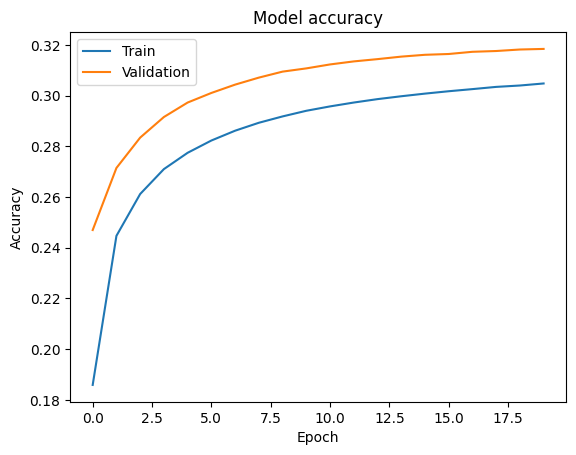

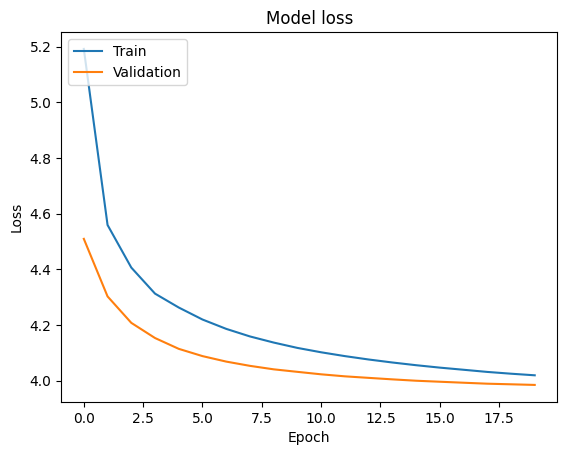

In [ ]:
plot_history(history_simple)

In [ ]:
def build_model(rnn_units=256, output_dim=128, dropout_rate=0.2):
    # -- Encoder Context --
    context_input = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="context_input")
    context_embedding = Embedding(input_dim=context_tv.vocabulary_size(), output_dim=output_dim, mask_zero=True)(context_input)
    context_embedding = keras.layers.LayerNormalization()(context_embedding)
    context_embedding = Dropout(dropout_rate)(context_embedding)
    context_conv = keras.layers.Conv1D(output_dim, kernel_size=3, padding='same', use_bias=False, name="conv")(context_embedding)
    context_conv = context_conv + context_embedding
    context_lstm = GRU(rnn_units, return_sequences=True, return_state=True)
    context_lstm_out, context_state_h, context_state_c = context_lstm(context_conv)
    context_lstm_out = Dropout(dropout_rate)(context_lstm_out)

    # -- Encoder T9 --
    t9_input = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="t9_input")
    t9_embedding = Embedding(input_dim=input_t9_tv.vocabulary_size(), output_dim=output_dim, mask_zero=True)(t9_input)
    t9_embedding = keras.layers.LayerNormalization()(t9_embedding)
    t9_embedding = Dropout(dropout_rate)(t9_embedding)
    t9_conv = keras.layers.Conv1D(output_dim, kernel_size=3, padding='same', use_bias=False, name="conv_t9")(t9_embedding)
    t9_conv = t9_conv + t9_embedding
    t9_lstm = GRU(rnn_units, return_sequences=True, return_state=True)
    t9_lstm_out, t9_state_h, t9_state_c = t9_lstm(t9_conv)
    t9_lstm_out = Dropout(dropout_rate)(t9_lstm_out)

    # -- Combinaison des états --
    combined_state_h = Dense(rnn_units, activation='tanh')(Concatenate(axis=-1, name="concatenated_state_h")([context_state_h, t9_state_h]))
    combined_state_c = Dense(rnn_units, activation='tanh')(Concatenate(axis=-1, name="concatenated_state_c")([context_state_c, t9_state_c]))

    # -- Decoder --
    decoder_input = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="decoder_input")
    decoder_embedding = Embedding(input_dim=target_tv.vocabulary_size(), output_dim=output_dim, mask_zero=True)(decoder_input)
    decoder_embedding = keras.layers.LayerNormalization()(decoder_embedding)
    decoder_embedding = Dropout(dropout_rate)(decoder_embedding)
    decoder_conv = keras.layers.Conv1D(output_dim, kernel_size=3, padding='same', use_bias=False, name="conv_decoder")(decoder_embedding)
    decoder_embedding = decoder_embedding + decoder_conv
    decoder_lstm = GRU(rnn_units, return_sequences=True, return_state=True)
    decoder_lstm_out, _, _ = decoder_lstm(decoder_embedding, initial_state=[combined_state_h, combined_state_c])
    decoder_lstm_out = Dropout(dropout_rate)(decoder_lstm_out)

    # -- Attention --
    encoder_combined = Concatenate()([context_lstm_out, t9_lstm_out])  # Dimension : (batch, seq_len, 2*rnn_units)
    encoder_combined = Dense(rnn_units, activation='relu')(encoder_combined)  # Réduction à rnn_units (256)
    attention = Attention()([decoder_lstm_out, encoder_combined])  # Dimensions maintenant compatibles

    # -- Concatenation + Sortie --
    decoder_combined = Concatenate(axis=-1, name="merged_features")([decoder_lstm_out, attention])
    dense = Dense(rnn_units, activation='relu')(decoder_combined)
    dense = Dropout(dropout_rate)(dense)
    output = Dense(target_tv.vocabulary_size(), activation='softmax')(dense)

    model = Model(inputs=[context_input, t9_input, decoder_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv_t9' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv_decoder' (of type Conv1D) was passed an input with a mask

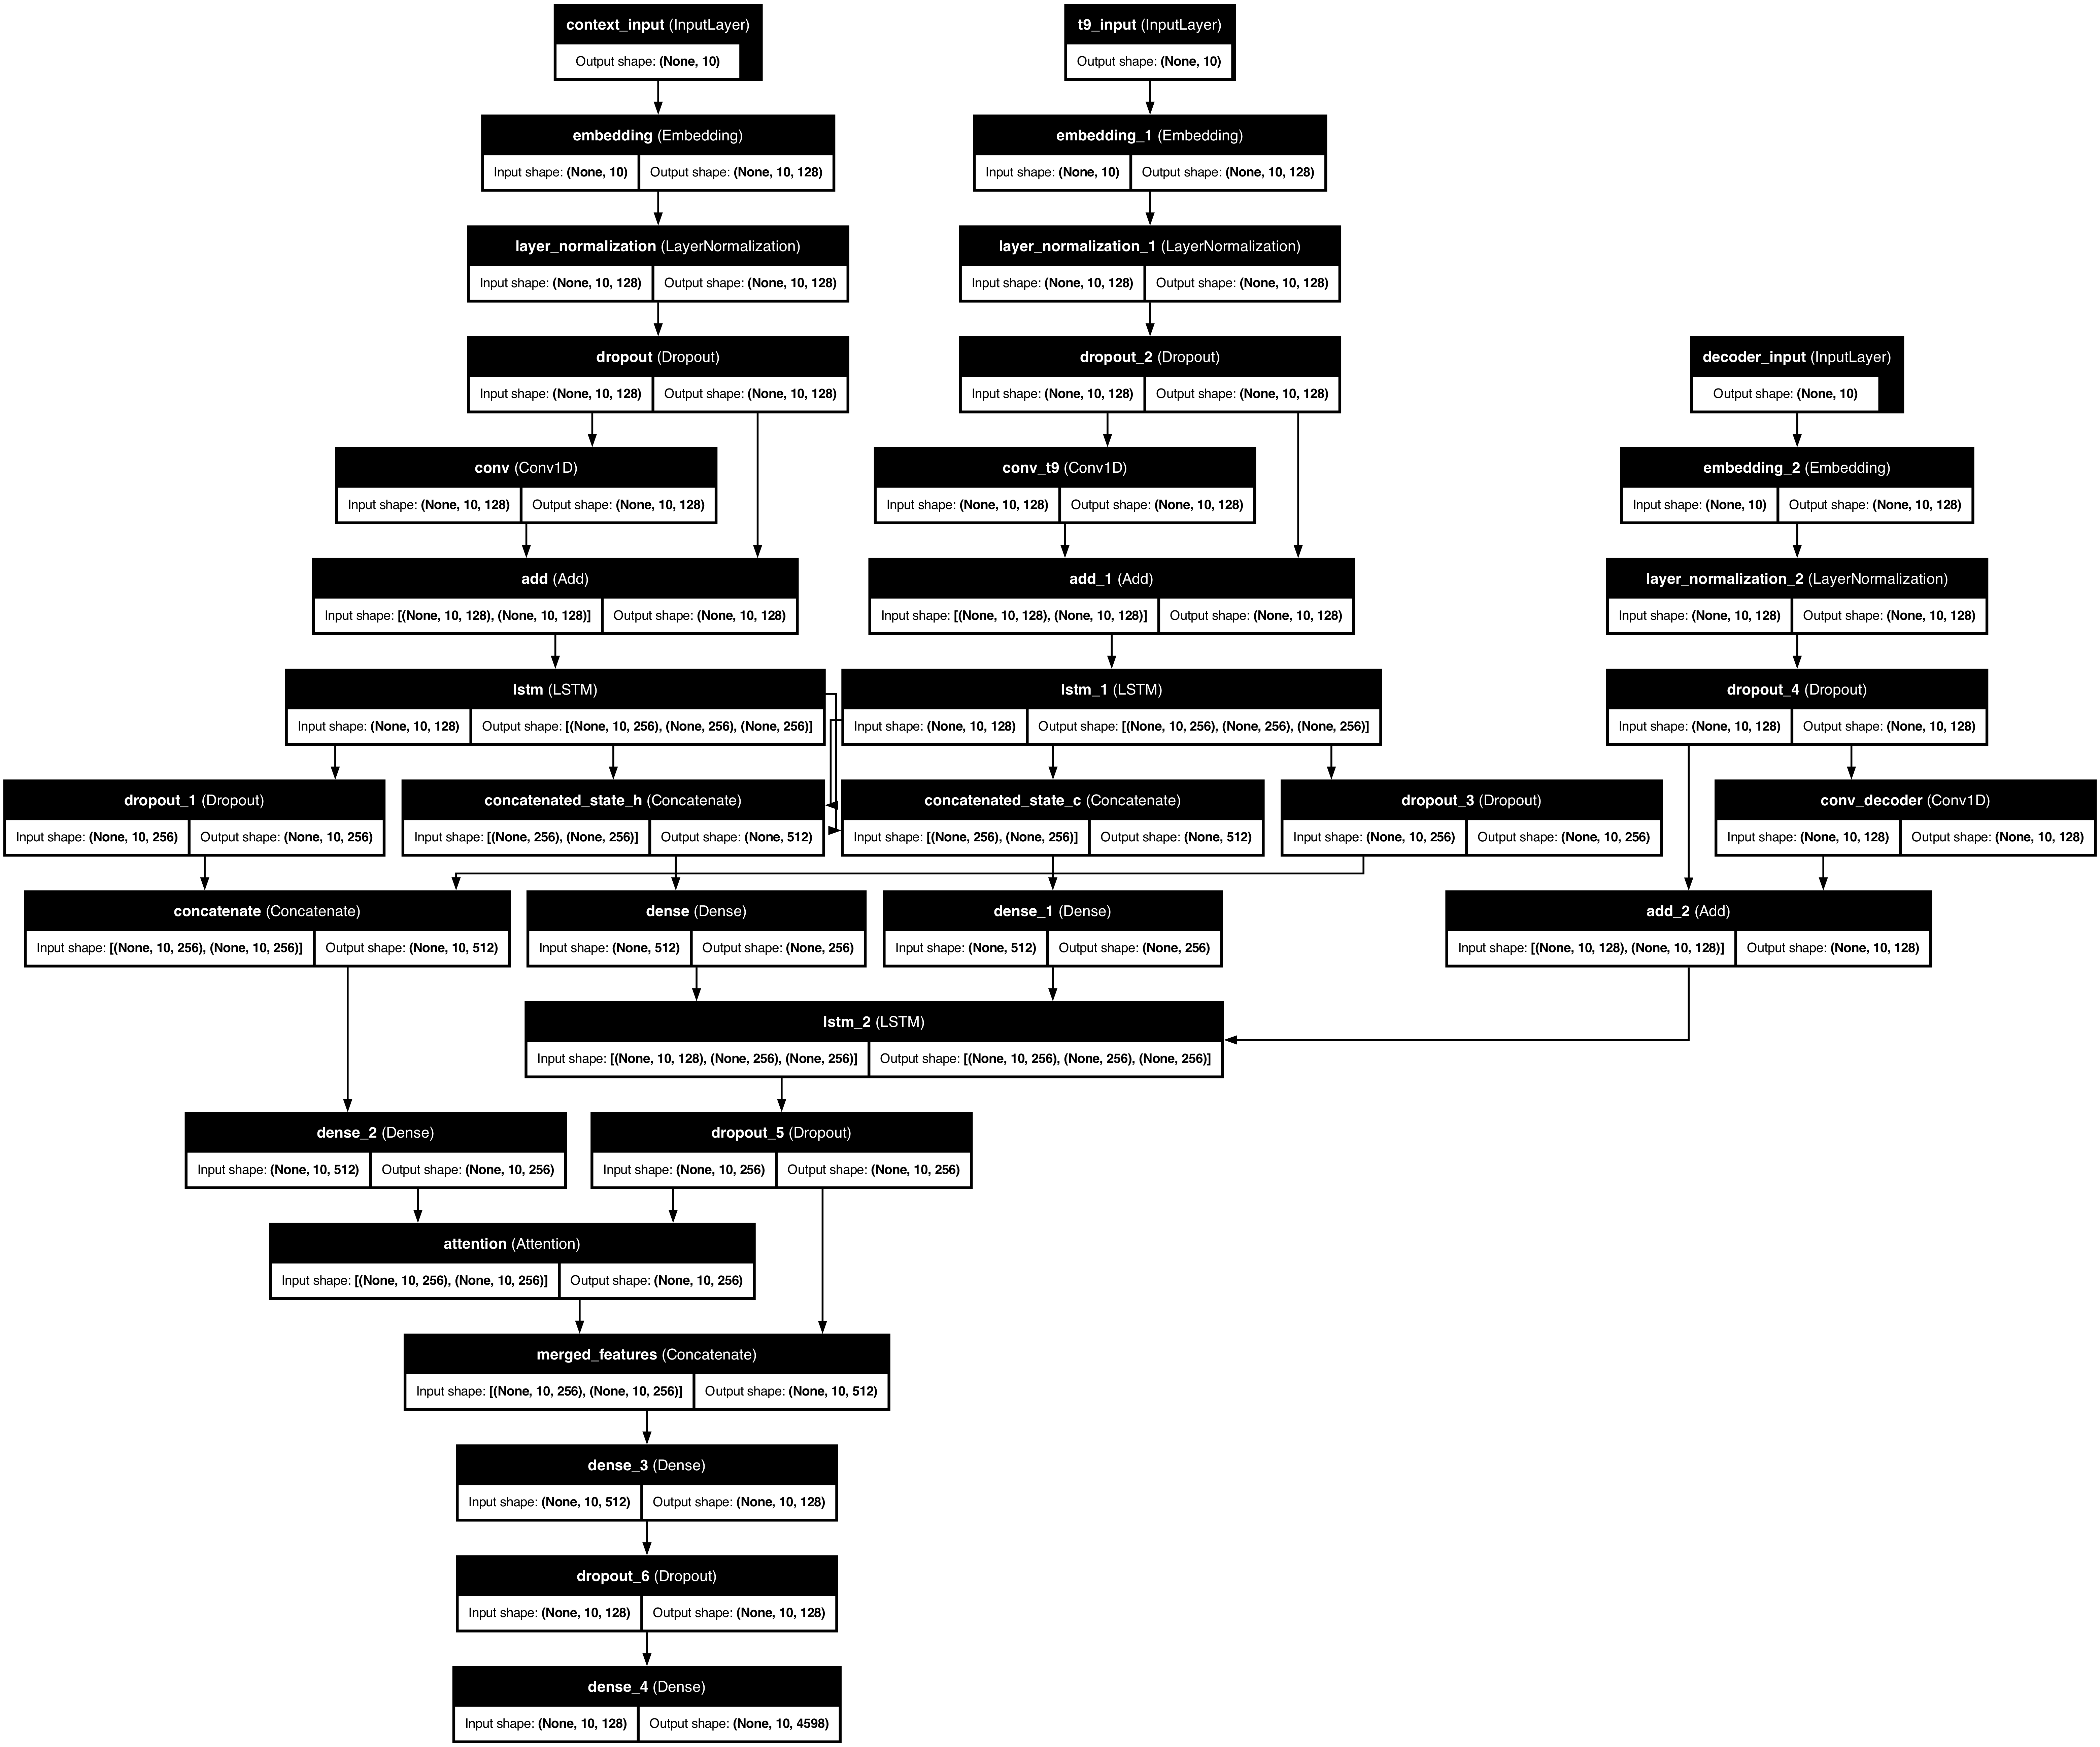

In [8]:
# Visualiser le modèle
model = build_model()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [ ]:
def build_hyper_model(hp):
    rnn_units = hp.Choice('rnn_units', [64, 128, 256, 512])
    output_dim = hp.Choice('output_dim', [32, 64, 128, 256]) 
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.8, step=0.2)
    return build_model(rnn_units, output_dim, dropout_rate)

# Créer un objet tuner
tuner = keras_tuner.RandomSearch(
    build_hyper_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='chinese_news_tuning'
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


tuner.search(
    ds_train.take(nb_train_samples),
    epochs=10,
    validation_data=ds_val.take(nb_val_samples),
    callbacks=[early_stopping]
)


# Obtenir le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

tuner.results_summary()

Trial 9 Complete [00h 22m 19s]
val_accuracy: 0.9167904853820801

Best val_accuracy So Far: 0.9546752572059631
Total elapsed time: 04h 37m 08s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
64                |256               |lstm_units
128               |128               |output_dim
0.8               |0                 |dropout_rate

Epoch 1/10
3845/4702 ━━━━━━━━━━━━━━━━━━━━ 54:56 4s/step - accuracy: 0.0343 - loss: 6.3674

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:")
print(f"rnn_units: {best_hyperparameters.get('rnn_units')}")
print(f"output_dim: {best_hyperparameters.get('output_dim')}")
print(f"dropout_rate: {best_hyperparameters.get('dropout_rate')}")
print(f"dense_units_output: {best_hyperparameters.get('dense_units_output')}")

Best hyperparameters:
lstm_units: 256
output_dim: 256
dropout_rate: 0.0
dense_units_output: 512


In [ ]:
model = build_model(
    rnn_units=best_hyperparameters.get('rnn_units'),
    output_dim=best_hyperparameters.get('output_dim'),
    dropout_rate=best_hyperparameters.get('dropout_rate'),
)


history = model.fit(
    ds_train.take(nb_train_samples),
    validation_data=ds_val.take(nb_val_samples),
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 416s 88ms/step - accuracy: 0.8227 - loss: 1.2679 - val_accuracy: 0.9127 - val_loss: 0.6656
Epoch 2/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 410s 87ms/step - accuracy: 0.9167 - loss: 0.6283 - val_accuracy: 0.9481 - val_loss: 0.3602
Epoch 3/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 412s 88ms/step - accuracy: 0.9491 - loss: 0.3622 - val_accuracy: 0.9492 - val_loss: 0.4503
Epoch 4/20
  68/4702 ━━━━━━━━━━━━━━━━━━━━ 6:46 88ms/step - accuracy: 0.9492 - loss: 0.4394

KeyboardInterrupt: 

In [ ]:
# sauvegarder le modèle
model.save('models/model.keras')

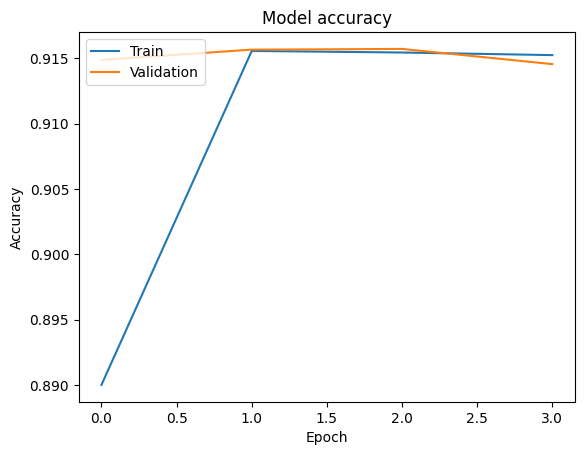

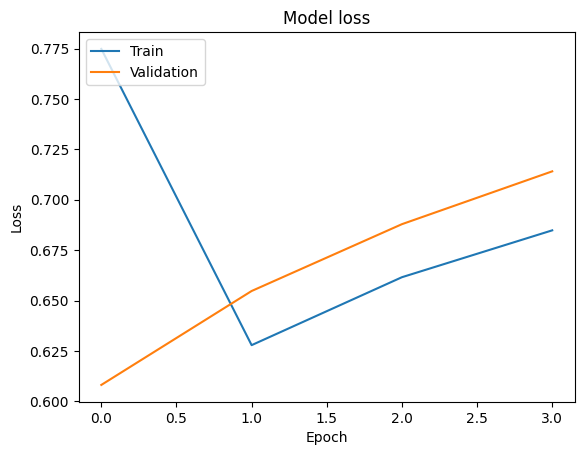

In [ ]:
plot_history(history)

# Évaluation

In [21]:
def evaluate_models(model_simple, model_full, ds_test):
    print("Évaluation du modèle simple...")
    loss_simple, acc_simple = model_simple.evaluate(ds_test, verbose=1)

    print("\nÉvaluation du modèle avec attention...")
    loss_full, acc_full = model_full.evaluate(ds_test, verbose=1)

    print(f"\nRésultats :")
    print(f"Modèle simple - Perte : {loss_simple:.4f}, Précision : {acc_simple:.4f}")
    print(f"\nModèle avec attention - Perte : {loss_full:.4f}, Précision : {acc_full:.4f}")

    return {
        "simple": {"loss": loss_simple, "accuracy": acc_simple},
        "full": {"loss": loss_full, "accuracy": acc_full}
    }

# Charger les deux modèles depuis les fichiers
model_simple = keras.models.load_model("models/simple_model.keras")
model_full = keras.models.load_model("models/model.keras")

# Évaluer
results = evaluate_models(model_simple, model_full, ds_test)

Évaluation du modèle simple...
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.3120 - loss: 4.0475

Évaluation du modèle avec attention...
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 58s 25ms/step - accuracy: 0.2567 - loss: 4.8403

Résultats :
Modèle simple - Perte : 4.0257, Précision : 0.3134

Modèle avec attention - Perte : 4.8016, Précision : 0.2587


# Génération